## Report 31/10/2022


Here we use data from all countries with titles and abstracts ready available in English. These are: Australia, Canada, 'Europe', India, Ireland, New Zealand, UK and USA. For these analysis, we also excluded the medical data (e.g. MRC, NIH...).


In [2]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# read in all raw data

# path to the file with all paths to files
paths = "/home/flavia/Projects/Funding-Landscape/code/supporting-files/directories-path/titles-abstracts-dir-STEM.txt"

# read file with all paths to files
paths_df = pd.read_csv(paths, names = ["fn","funding_body"], delimiter= " ")

# create empty lists to store number of documents and country name
n_docs = []
country = []

# for line in file with paths to files
for fn in paths_df["fn"]:
    # count the number of lines in each file (each line is a separate document)
    n_docs.append(sum(1 for line in open(fn)))
    # get the name of the country (index 7/position 6) from the file path (line)
    country.append(fn.split("/")[7])

# store number of lines and country name 
paths_df["n_docs"] = n_docs
paths_df["country"] = country

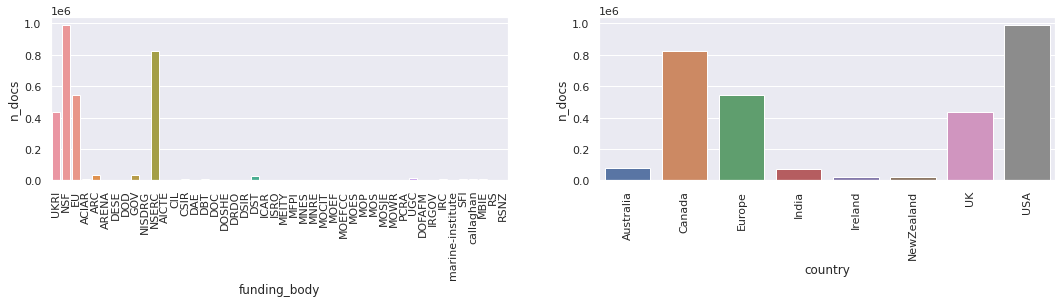

In [5]:
# plot number of documents per research council and funding body
sns.set(rc={'figure.figsize':(18,3)}) 

fig, axs = plt.subplots(ncols=2)

sns.barplot(data = paths_df, x = "funding_body", y = "n_docs", ax=axs[0]) 
axs[0].tick_params(axis='x', labelrotation=90,)

df_agg = paths_df.groupby("country").agg({"n_docs":"sum"}).reset_index()
sns.barplot(data = df_agg, x = "country", y = "n_docs", ax=axs[1]) 
axs[1].tick_params(axis='x', labelrotation=90)


In [20]:
# pandas version is too slow
# n_docs = []

# for fn in paths_df["fn"]:
#     doc = pd.read_csv(fn)

#     n_docs.append(len(doc))

#     country.append(fn.split("/")[7])

In [6]:
# Calculate the average coherence scores for a given topic model using the individual topic coherence from the diagnostic files
# created by Mallet when fitting the LDA model for each number of topics. We stored values in the previously created dictionary.
base_path = '../results/fine-scale/mallet-models/STEM-ENG/'

topic_paths = os.listdir(base_path)

data = {"n_topics":[], "rep":[], "coherence":[], "perplexity":[]}

# for folders (dif topic models) in path
for t in topic_paths:

    # use folders within not txt files in this dir
    if not t.endswith(".txt"):
        # get the path to a speficic model with t number of topics
        rep_path = os.listdir(base_path + t)
        
        ## get number of replicates (reps) for model with t number of topics
        # get the number of topics
        topics = (t.split("-")[0])
        # get the replicates for each topic
        reps = set([(x.split("-")[0]) for x in rep_path])
        
        #get perplexity for topic t
        for r in reps:
            ## get perplexity
            # get file name
            LP_fn = "-".join([r,topics,"topics-log-probability"])
            ## get perplexity from file LP_fn
            LP = sum([float(x) for x in open("/".join([base_path,t,LP_fn]))])

            # get path to file with number of tokens per document
            doc_length_path = base_path + r + "-doc-lengths.txt"

            # get total number of tokens per document
            N_words = sum([float(x) for x in open(doc_length_path)])

            # calculate perplexity per model (-perplexity per document/number of tokens in each document) 
            perp = (-LP / N_words)

            ## get coherence
            # get path to file with coherence values
            coh_fn = "-".join([r,topics,"topics-diagnostics.xml"])
            # parse xml format
            tree = ET.parse("/".join([base_path,t,coh_fn]))
            root = tree.getroot()
            # get coherence values from file
            c = [float(child.attrib['coherence']) for child in root]

            # create dataframe with coherence, model, replicates, perplexity
            for i in c:
                data["coherence"].append(i)
                data["n_topics"].append(int(topics))
                data["rep"].append(int(r))
                data["perplexity"].append(perp)


<AxesSubplot:xlabel='n_topics', ylabel='perplexity'>

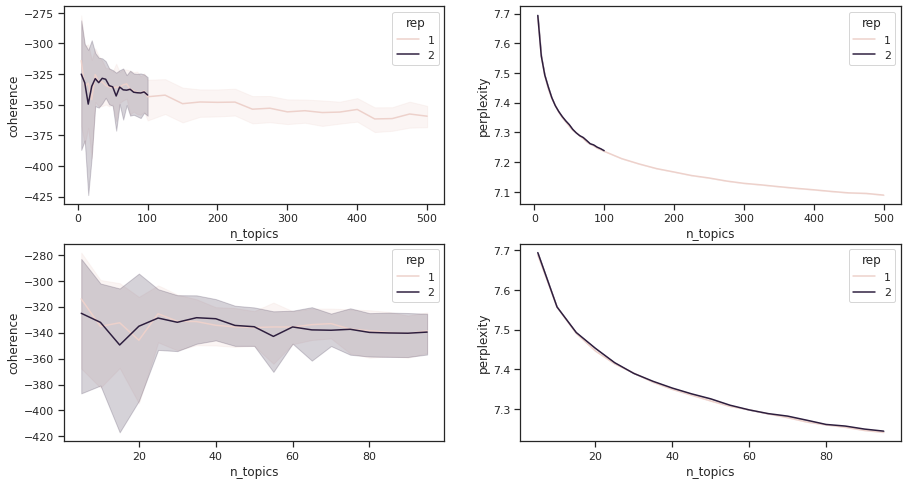

In [22]:
# plot settings
sns.set(rc={'figure.figsize':(15,8)}) 
sns.set_theme(style="ticks")
fig, axs = plt.subplots(ncols=2, nrows=2)

# turn dict into df
df = pd.DataFrame(data)
# remove the 3 replicate because it is incomplete (I have not finished running it to 100 topics)
df = df.query("rep!=3")

# Plot 
sns.lineplot(x="n_topics", y="coherence", hue = "rep",  data=df, ax = axs[0,0])
sns.lineplot(x="n_topics", y="perplexity", hue = "rep",  data=df, ax = axs[0,1])

sns.lineplot(x="n_topics", y="coherence", hue = "rep", data=df.query("n_topics < 100"), ax = axs[1,0])
sns.lineplot(x="n_topics", y="perplexity", hue = "rep", data=df.query("n_topics < 100"), ax = axs[1,1])

### Including medical data

In [23]:
base_path = '../results/fine-scale/mallet-models/ENG-speaking-countries/'

topic_paths = os.listdir(base_path)

data = {"n_topics":[], "rep":[], "coherence":[], "perplexity":[]}

# N_words = sum([float(x) for x in open(doc_length_path)])

for t in topic_paths:
    if not t.endswith(".txt"):
        rep_path = os.listdir(base_path + t)
        
        #get n_reps
        topics = (t.split("-")[0])
        reps = set([(x.split("-")[0]) for x in rep_path])
        
        #get perplexity for topic t
        for r in reps:
            # get perplexity
            LP_fn = "-".join([r,topics,"topics-log-probability"])
            LP = sum([float(x) for x in open("/".join([base_path,t,LP_fn]))])

            doc_length_path = base_path + r + "-doc-lengths.txt"

            N_words = sum([float(x) for x in open(doc_length_path)])
            perp = (-LP / N_words)

            #get coherence
            coh_fn = "-".join([r,topics,"topics-diagnostics.xml"])
            tree = ET.parse("/".join([base_path,t,coh_fn]))
            root = tree.getroot()

            #get coherence
            c = [float(child.attrib['coherence']) for child in root]

            for i in c:
                data["coherence"].append(i)
                data["n_topics"].append(int(topics))
                data["rep"].append(int(r))
                data["perplexity"].append(perp)


<AxesSubplot:xlabel='n_topics', ylabel='perplexity'>

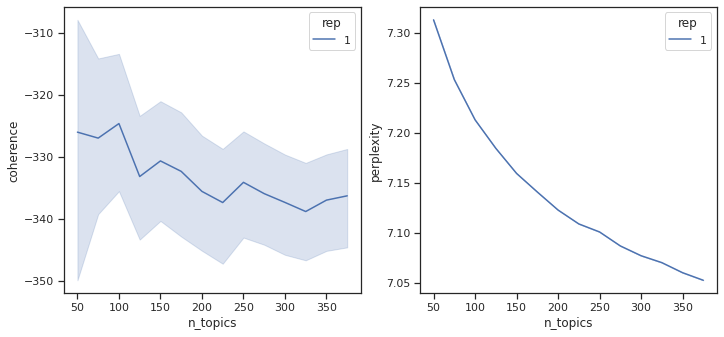

In [24]:
sns.set(rc={'figure.figsize':(11.7,5.27)}) 
sns.set_theme(style="ticks")

fig, axs = plt.subplots(ncols=2, nrows=1)

df = pd.DataFrame(data)

# Plot 
sns.set_theme(style="ticks")
sns.lineplot(x="n_topics", y="coherence", hue = "rep",  data=df, ax = axs[0])
sns.lineplot(x="n_topics", y="perplexity", hue = "rep",  data=df, ax = axs[1])
